# **Which of the playing teams in NHL have better public support and what is the overall public opinion on a particular team?**



In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import glob
import os
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from emot.emo_unicode import UNICODE_EMOJI
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import nltk
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
import seaborn as sns
#nltk.download('punkt')

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
import pandas_bokeh

%matplotlib inline

In [3]:
data_files = r"Tweets"
team_tweets_df= pd.DataFrame()
team_tweets_df= pd.concat(map(pd.read_csv,glob.glob(os.path.join(data_files,'Team*.csv'))), ignore_index= True)
team_tweets_df.to_csv("Team_Tweets_NHL.csv", index = False)
team_tweets_df.drop_duplicates(inplace=True)

In [4]:
team_tweets_df.head(10)

,Team,Date,Tweet
0,Boston Bruins,2022-03-25 21:31:26+00:00,@PowellAnalytics Bobby Orr. Boston Bruins.
1,Boston Bruins,2022-03-25 21:23:57+00:00,Don't look now but Erik Haula has been hitting...
2,Boston Bruins,2022-03-25 21:23:23+00:00,Tuukka Rask of Boston Bruins earns tribute in ...
3,Boston Bruins,2022-03-25 21:15:52+00:00,"Or, according to the announcements, the Boston..."
4,Boston Bruins,2022-03-25 21:13:41+00:00,RT @BR_Athletics_MA: Huge congratulations to J...
5,Boston Bruins,2022-03-25 21:10:22+00:00,How DeBrusk feels about staying with Bruins de...
6,Boston Bruins,2022-03-25 21:09:36+00:00,Bruins' failure to add forward depth at trade ...
7,Boston Bruins,2022-03-25 21:09:23+00:00,"Bruins improved at trade deadline, but path to..."
8,Boston Bruins,2022-03-25 21:09:01+00:00,Bruins cement status as legit contender with s...
9,Boston Bruins,2022-03-25 21:07:43+00:00,RT @BitSler: 🏒#NHL in 15 min 🏒\n\nBET NOW ➡️ h...


# Tweets cleaning

Cleaning is an important step before performing text analysis. Before performing sentiment analysis, we used regular expressions to remove hyperlinks, hashtags, mentions of other twitter users starting with ‘@’, retweets starting with ‘RT’ and emojis.

In [5]:
#removing hyoerlinks
team_tweets_df["Tweet"] = team_tweets_df["Tweet"].str.replace(r'https?:\/\/.*[\r\n]*', '').str.strip()

#remove # and @ from tweets
team_tweets_df["Tweet"] = team_tweets_df["Tweet"].str.replace(r'@\w+|#\w+|RT|', '').str.strip()

In [6]:
# Removing Emojis
def handle_emojis(tweet):
    for emot in UNICODE_EMOJI:
        tweet = tweet.replace(emot, "")
    return tweet

team_tweets_df["Tweet"] = team_tweets_df["Tweet"].apply(handle_emojis)

# Sentiment Stats of each team

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER is used to quantify how much positive or negative emotion the text has.Here, SentimentIntensityAnalyzer() is an object and polarity_scores method returns a dict having positive, negative, neutral and compound scores. The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive). The more Compound score closer to +1, the higher the positivity of the text. For our case, we concluded that the tweets with compound scores between 0.5 and 1 are positive, -0.5 and -1 as negative and remaining as neutral.


In [7]:
team_names = team_tweets_df["Team"].unique()
analyzer = SentimentIntensityAnalyzer()
pd.options.mode.chained_assignment = None

Team_arr = []
positive_scores = []
negative_scores = []
neutral_scores = []

def determine_polarity(tweet):
    pol_scores = analyzer.polarity_scores(tweet) 
    compound_score = pol_scores["compound"]
    if compound_score >= 0.5:
        return "positive"
    elif compound_score <= -0.5:
        return "negative"
    else:
        return "neutral"
team_tweets_df1 = pd.DataFrame()    
for team in team_names:
    curr_team_df = team_tweets_df.loc[team_tweets_df["Team"] == team]
    curr_team_df["polarity"] = curr_team_df["Tweet"].apply(determine_polarity)
    team_tweets_df1 = team_tweets_df1.append(curr_team_df)
    pos_num = curr_team_df[curr_team_df["polarity"]== "positive"].count()["Tweet"]
    neg_num = curr_team_df[curr_team_df["polarity"]== "negative"].count()["Tweet"]
    neu_num = curr_team_df[curr_team_df["polarity"]== "neutral"].count()["Tweet"]
    
    Team_arr.append(team)
    positive_scores.append(pos_num)
    negative_scores.append(neg_num)
    neutral_scores.append(neu_num)
    
    print("\n=========== ",team ," Tweets Sentiment Stats: =================")
    print("Positive Tweets: ", pos_num)
    print("Negative Tweets: ", neg_num)
    print("Neutral Tweets:  ", neu_num)

Team_sentiment_stats_df = pd.DataFrame({"Team" : Team_arr,
                              "Positive_tweet" : positive_scores,
                              "Negative_tweet" : negative_scores,
                              "Neutral_tweet" : neutral_scores
                                       })
print(Team_sentiment_stats_df)

Team_sentiment_stats_df.to_csv('Teams_sentiment.csv')


===========  Boston Bruins  Tweets Sentiment Stats: =================
Positive Tweets:  1027
Negative Tweets:  231
Neutral Tweets:   2741

===========  Buffalo Sabres  Tweets Sentiment Stats: =================
Positive Tweets:  1327
Negative Tweets:  131
Neutral Tweets:   2275

===========  Detroit Red Wings  Tweets Sentiment Stats: =================
Positive Tweets:  725
Negative Tweets:  204
Neutral Tweets:   2538

===========  Florida Panthers  Tweets Sentiment Stats: =================
Positive Tweets:  995
Negative Tweets:  117
Neutral Tweets:   2693

===========  Montreal Canadiens  Tweets Sentiment Stats: =================
Positive Tweets:  730
Negative Tweets:  125
Neutral Tweets:   2864

===========  Ottawa Senators  Tweets Sentiment Stats: =================
Positive Tweets:  713
Negative Tweets:  136
Neutral Tweets:   2605

===========  Tampa Bay Lightning  Tweets Sentiment Stats: =================
Positive Tweets:  991
Negative Tweets:  198
Neutral Tweets:   2601

==========

In [8]:
team_tweets_df1.head(5)

,Team,Date,Tweet,polarity
0,Boston Bruins,2022-03-25 21:31:26+00:00,Bobby Orr. Boston Bruins.,neutral
1,Boston Bruins,2022-03-25 21:23:57+00:00,Don't look now but Erik Haula has been hitting...,neutral
2,Boston Bruins,2022-03-25 21:23:23+00:00,Tuukka Rask of Boston Bruins earns tribute in ...,neutral
3,Boston Bruins,2022-03-25 21:15:52+00:00,"Or, according to the announcements, the Boston...",neutral
4,Boston Bruins,2022-03-25 21:13:41+00:00,: Huge congratulations to Justin Peters who wi...,positive


In [9]:
data_senti = Team_sentiment_stats_df[['Team','Positive_tweet','Negative_tweet']]
data_senti.set_index('Team', inplace=True)
data_senti['Negative_tweet'] = data_senti['Negative_tweet'] * (-1)
#data_senti.sort_values(by = "Positive_tweet", inplace = True, ascending = True)
#data_senti

In [10]:
pandas_bokeh.output_notebook()

In [11]:

#from plot_bokeh import barh
data_senti.plot_bokeh.barh(title='Fans Sentiment towards NHL Teams')
data_senti.to_csv("Team_Sentiments.csv")

# Topic Modelling - LDA and LSI

A Topic Model is a type of statistical model for discovering the abstract “topics” that occur in a collection of documents.

Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

Latent Semantic Indexing, also known as latent semantic analysis, is a mathematical practice that helps classify and retrieve information on particular key terms and concepts using singular value decomposition (SVD).


In [12]:
#remove punctuation
team_tweets_df1["Tweet"] = team_tweets_df1["Tweet"].str.replace('[{}]'.format(string.punctuation), '')

In [13]:
#remove stop words
import nltk
nltk.download('stopwords')
stop_wrds = stopwords.words('english')

def stop_word_removal(tweet):
    return ' '.join([word for word in tweet.split() if word not in stop_wrds])

team_tweets_df1["Tweet"] = team_tweets_df1["Tweet"].apply(stop_word_removal)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
#tokenization
tokenizer = TweetTokenizer(
    preserve_case=False,
    strip_handles=True,
    reduce_len=True)

def tokenization(tweet):
    token_sent = tokenizer.tokenize(tweet)
    return token_sent

team_tweets_df1["Tweet"] = team_tweets_df1["Tweet"].apply(tokenization)
# team_tweets_df.to_csv('check.csv', index = False)

In [15]:
#lemmatization
import spacy 
def lemmatization(texts, team_name, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    split_team = str.lower(team_name).split()
    split_team.append(split_team[-1][:-1])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ for token in doc if (token.pos_ in allowed_postags) and (token.lemma_ not in split_team) and (len(token.lemma_) > 3)]))
    return texts_out

nlp = spacy.load("en_core_web_sm")
#keeping only Noun, Adj, Verb, Adverb
positive_team_name = Team_sentiment_stats_df.iloc[Team_sentiment_stats_df["Positive_tweet"].idxmax()]["Team"]
positive_team_df =  team_tweets_df1.loc[team_tweets_df1["Team"] == positive_team_name]
positive_team_df["Tweet"] = lemmatization(positive_team_df["Tweet"], positive_team_name, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
positive_team_df.head(5)

,Team,Date,Tweet,polarity
500,Buffalo Sabres,2022-03-25 22:33:41+00:00,,neutral
501,Buffalo Sabres,2022-03-25 22:30:03+00:00,free pick capital preview prediction,positive
502,Buffalo Sabres,2022-03-25 22:28:24+00:00,today pick capital pick available,neutral
503,Buffalo Sabres,2022-03-25 22:26:21+00:00,roll month keep trend tonight,neutral
504,Buffalo Sabres,2022-03-25 22:25:56+00:00,more tonight game capital ovechkin dominance y...,neutral


In [16]:
#Hyperparameter tuning for LDA model
def lda_hyperparameter(team_df):
  vectorizer = CountVectorizer(analyzer='word',       
                               min_df=10,                        
                               stop_words='english',             
                               lowercase=True,                   
                               #ngram_range=(1, 2)
                              )

  vector_data = vectorizer.fit_transform(positive_team_df["Tweet"])

  #Checking the data sparsity
  data_dense_vec = vector_data.todense()
  print("sparsity: ", ((data_dense_vec > 0).sum()/data_dense_vec.size)*100, "%")
  # Define Search Param
  search_params_hyper = {'n_components': [3, 10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

  #lda Model
  lda_mod = LatentDirichletAllocation()

  # Grid Search Class
  model_lda = GridSearchCV(lda_mod, param_grid=search_params_hyper)

  #Grid Search
  model_lda.fit(vector_data)

  # Best LDA Model
  best_lda = model_lda.best_estimator_

  # Best LDA model's Log Likelihood Score
  print("Best Log Likelihood Score: ", model_lda.best_score_)

  # Perplexity
  print("Model Perplexity: ", best_lda.perplexity(vector_data))

  num_topics = [3, 10, 15, 20, 25, 30]

  scores_mean = model_lda.cv_results_['mean_test_score'].tolist()
  print(scores_mean)
  log_like_5 = scores_mean[0:6]
  log_like_7 = scores_mean[6:12]
  log_like_9 = scores_mean[12:18]

  plt.figure(figsize=(12, 8))
  plt.plot(num_topics, log_like_5, label='0.5')
  plt.plot(num_topics, log_like_7, label='0.7')
  plt.plot(num_topics, log_like_9, label='0.9')
  plt.title("Choosing Best LDA Model")
  plt.xlabel("# Topics")
  plt.ylabel("Log Likelyhood Scores")
  plt.legend(title='Learning decay', loc='best')
  plt.show()

  return best_lda, vector_data, vectorizer 

sparsity:  1.0254974064242748 %
Best Log Likelihood Score:  -16262.886832829317
Model Perplexity:  186.46857717787518
[-16360.86859748023, -17381.450162532165, -17968.598143152845, -18290.17343175607, -18723.882402580675, -18935.978005741217, -16262.886832829317, -17412.559309067336, -17964.539243468036, -18398.67478478677, -18911.766483402225, -19138.379353623266, -16316.667308844237, -17434.006070534797, -17841.509997067315, -18393.335248181636, -18781.81017770654, -18927.38890039883]


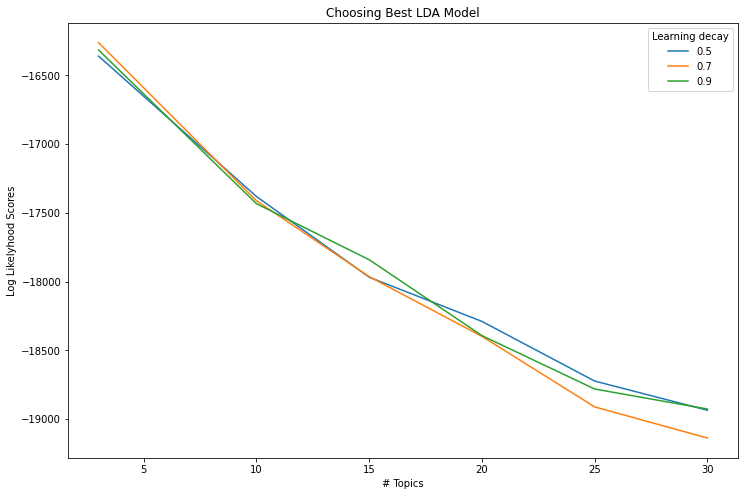

In [17]:
#Best LDA model for positive team
best_lda, data_vectorized, vectorizer = lda_hyperparameter(positive_team_df)

In [18]:
#visualization for LDA
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
2     -1015.700562  1338.981201       1        1  35.513009
1      -387.996002  -373.316162       2        1  33.258286
0     -2184.745605   -60.565800       3        1  31.228705, topic_info=          Term        Freq       Total Category  logprob  loglift
315       want  393.000000  393.000000  Default  30.0000  30.0000
64      energy  354.000000  354.000000  Default  29.0000  29.0000
145  legendary  320.000000  320.000000  Default  28.0000  28.0000
121      honor  318.000000  318.000000  Default  27.0000  27.0000
244      score  220.000000  220.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
100       good   57.091235  165.818016   Topic3  -4.2717   0.0976
97        goal   55.265672  179.545376   Topic3  -4.3042  -0.0144
9     announce   35.610916   53.919326   Topic3  -4.7437   0.7490
249   shootout   38.477309   82.855544   Topic3  -4.6662   0.3968
29     capital   34.402703  151.991837   Topic3  -4.7782  -0.3219

[158 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4         2  0.979405     afraid
9         1  0.333832   announce
9         3  0.667664   announce
24        1  0.988072      bring
29        1  0.769778    capital
...     ...       ...        ...
316       1  0.994746      watch
316       3  0.011177      watch
318       3  0.987464       week
327       1  0.998030       year
328       1  0.984574  yesterday

[166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

The below are the public opinions for the team that has good public support

- Topic 1 - game stats.
- Topic 2 - Tage Thompson's recent performance
- Topic 3 - Fan's support and celebration over wins.

Text(0.5, 1.0, 'Segregation of Tweet Clusters')

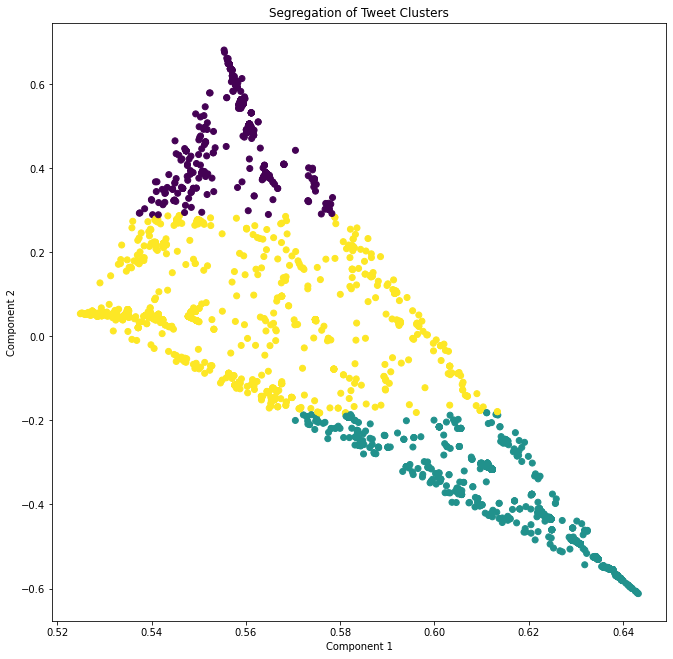

In [19]:
#visualize the clusters of documents in a 2D space
from sklearn.cluster import KMeans
lda_out_inp = best_lda.transform(data_vectorized)
svd_model = TruncatedSVD(n_components=2)  # 2 components
out_lda_svd = svd_model.fit_transform(lda_out_inp)

# X and Y axes of the plot using SVD decomposition
x = out_lda_svd[:, 0]
y = out_lda_svd[:, 1]
clusters = KMeans(n_clusters=3, random_state=42).fit_predict(out_lda_svd)
plt.figure(figsize=(11, 11))
plt.scatter(x, y, c=clusters)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Tweet Clusters", )

In [20]:
#LSI model for positive team
import gensim
import gensim.corpora as corpora
from pprint import pprint

data_lemma = positive_team_df["Tweet"].to_numpy()
unicode_dataset = [d.split() for d in data_lemma]
id2word = corpora.Dictionary(unicode_dataset)
texts = unicode_dataset
corpus = [id2word.doc2bow(text) for text in texts]
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]] 
lsi_model = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=id2word, num_topics=3,chunksize=100)
pprint(lsi_model.print_topics())

[(0,
  '0.516*"want" + 0.502*"energy" + 0.490*"legendary" + 0.490*"honor" + '
  '0.023*"team" + 0.015*"love" + 0.012*"bill" + 0.012*"sport" + 0.011*"join" + '
  '0.010*"excited"'),
 (1,
  '0.512*"team" + 0.330*"game" + 0.246*"back" + 0.227*"throwback" + '
  '0.227*"bring" + 0.214*"support" + 0.198*"sale" + 0.194*"throw" + '
  '0.183*"capital" + 0.149*"score"'),
 (2,
  '0.427*"game" + -0.280*"throwback" + -0.279*"bring" + 0.263*"capital" + '
  '-0.254*"support" + -0.253*"sale" + -0.247*"throw" + -0.236*"team" + '
  '-0.224*"back" + 0.185*"goal"')]


The LSI model's results are similar to LDA's.

In [21]:
#keeping only Noun, Adj, Verb, Adverb
negative_team_name = Team_sentiment_stats_df.iloc[Team_sentiment_stats_df["Negative_tweet"].idxmax()]["Team"]
negative_team_df =  team_tweets_df1.loc[team_tweets_df1["Team"] == negative_team_name]
negative_team_df = negative_team_df[negative_team_df["polarity"] == "negative"]
negative_team_df["Tweet"] = lemmatization(negative_team_df["Tweet"], negative_team_name, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
negative_team_df.head(5)

,Team,Date,Tweet,polarity
9002,New Jersey Devils,2022-03-25 22:47:56+00:00,blackdevil just follow also nickname black sur...,negative
9003,New Jersey Devils,2022-03-25 22:41:47+00:00,request,negative
9010,New Jersey Devils,2022-03-25 21:47:22+00:00,last game play exemplify season turn early def...,negative
9011,New Jersey Devils,2022-03-25 21:41:27+00:00,capital,negative
9014,New Jersey Devils,2022-03-25 20:38:47+00:00,,negative


sparsity:  1.0254974064242748 %
Best Log Likelihood Score:  -16148.892719587302
Model Perplexity:  181.16935117046444
[-16148.892719587302, -17346.326223569376, -18051.50073385769, -18316.044416625617, -18608.1558147318, -19005.906401366923, -16366.240383970682, -17371.758980797305, -17912.657954651826, -18359.318259444186, -18820.581148483925, -19115.898847059783, -16328.19714989911, -17417.348892283335, -17893.468579899163, -18294.672387448616, -18774.774777756676, -19181.215244954386]


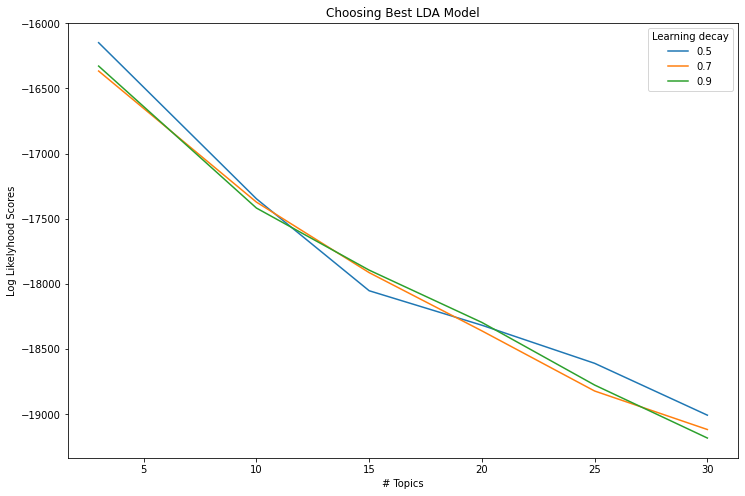

In [22]:
#best lda model for negative team
best_lda, data_vectorized, vectorizer = lda_hyperparameter(negative_team_df)

In [23]:
#LDA visualization for negative team
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
2     -1015.700562  1338.981201       1        1  36.964904
0      -387.996002  -373.316162       2        1  34.531642
1     -2184.745605   -60.565800       3        1  28.503454, topic_info=          Term        Freq       Total Category  logprob  loglift
315       want  402.000000  402.000000  Default  30.0000  30.0000
64      energy  362.000000  362.000000  Default  29.0000  29.0000
145  legendary  327.000000  327.000000  Default  28.0000  28.0000
121      honor  325.000000  325.000000  Default  27.0000  27.0000
280       team  379.000000  379.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
202      point   74.583916  155.835397   Topic3  -3.9131   0.5183
245     season   83.171781  191.228440   Topic3  -3.8041   0.4226
213   prospect   39.152747   72.514810   Topic3  -4.5575   0.6388
244      score   56.104408  224.622625   Topic3  -4.1978  -0.1321
285      think   26.746521   63.385932   Topic3  -4.9386   0.3923

[154 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
6         2  0.966926      ahead
17        3  0.973863       bear
18        2  0.985322       beat
21        3  0.949514   birthday
24        2  0.995098      bring
...     ...       ...        ...
319       3  0.943418    weekend
327       1  0.005016       year
327       2  0.080263       year
327       3  0.912993       year
328       3  0.975315  yesterday

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

The below are the public opinions for the team that has good public support

- Topic 1 - game stats.
- Topic 2 - Loss due to Jack Hughes injury.
- Topic 3 - Fan's support as well as criticism

Text(0.5, 1.0, 'Segregation of Tweet Clusters')

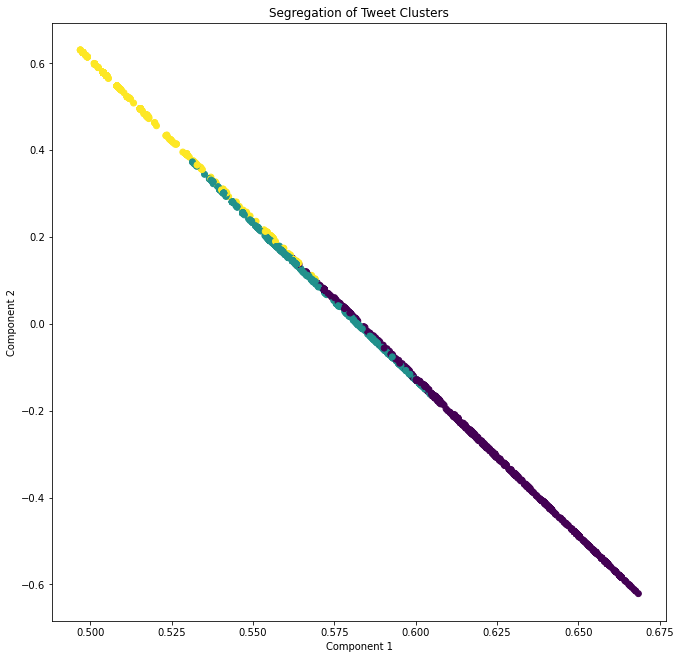

In [26]:
#visualize the clusters of documents in a 2D space - negative team
lda_out_inp = best_lda.transform(data_vectorized)
svd_model = TruncatedSVD(n_components=2)  # 2 components
out_lda_svd = svd_model.fit_transform(lda_out_inp)

# X and Y axes of the plot using SVD decomposition
x = out_lda_svd[:, 0]
y = out_lda_svd[:, 1]
clusters = KMeans(n_clusters=3, random_state=42).fit_predict(lda_out_inp)
plt.figure(figsize=(11, 11))
plt.scatter(x, y, c=clusters)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Tweet Clusters", )

In [25]:
#LSI model for negative team
data_lemma = negative_team_df["Tweet"].to_numpy()
unicode_dataset = [d.split() for d in data_lemma]
id2word = corpora.Dictionary(unicode_dataset)
texts = unicode_dataset
corpus = [id2word.doc2bow(text) for text in texts]
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]] 
lsi_model = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=id2word, num_topics=3,chunksize=100)
pprint(lsi_model.print_topics())

[(0,
  '0.432*"score" + 0.417*"goal" + 0.356*"history" + 0.355*"become" + '
  '0.355*"ever" + 0.354*"player" + 0.354*"abuse" + 0.048*"defeat" + '
  '0.025*"beat" + 0.025*"canuck"'),
 (1,
  '0.513*"panther" + 0.511*"defeat" + 0.475*"comeback" + 0.470*"complete" + '
  '0.060*"flame" + 0.058*"game" + -0.039*"abuse" + -0.039*"player" + '
  '-0.039*"ever" + -0.038*"become"'),
 (2,
  '0.437*"lose" + 0.376*"playoff" + 0.376*"eliminate" + 0.376*"contention" + '
  '0.367*"regulation" + 0.342*"tonight" + 0.311*"montreal" + 0.070*"canuck" + '
  '0.061*"second" + -0.055*"complete"')]


The LSI model's results are similar to that of LDA's